# Code for experiments with colored MNIST and Celeba


## 1. Imports


In [2]:
import logging
import os
import sys
from datetime import datetime
sys.path.append("..")

import gc
import json
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision.datasets as datasets
from torchvision.transforms import Compose, Resize, Normalize, ToTensor, Lambda
from IPython.display import clear_output

# This needed to use dataloaders for some datasets
from PIL import PngImagePlugin
from tqdm import trange

from src.mnistm_utils import MNISTM
from src.cunet import CUNet
from src.enot import SDE, integrate
from src.resnet2 import ResNet_D
from src.guided_samplers import PairedSubsetSampler, SubsetGuidedDataset, get_indicies_subset

%matplotlib inline


In [3]:
gc.collect()
torch.cuda.empty_cache()

## 2. Config

Dataset choosing in the first rows

Continue training in the last rows


In [3]:
NUM_LABELED = 10
DATASET = 'fmnist2mnist'
DATASET_PATH = '~/data/'
IMG_SIZE = 32
# the step number adding noise in diffusion process style
DIFFUSION_STEPS = 1000
PIVOTAL_LIST = [0, 20, 50, 100]

# the real batch_size = BATCH_SIZE * C_SIZE
BATCH_SIZE = 32 # a batch data random choice BATCH_SIZE class
C_SIZE = 2 # every class choiced put C_SIZE sample in batch data

DEVICE_IDS = [0]

# whether continue training, -1 means re-training, N > -1 means continue at sdeN or iteration N
# In this training strategy, the "sde" doesn't matter
CONTINUE = {"sde": -1, "iteration": -1}

OUTER_ITERS = 2001  # MAX_STEPS = 100001
INNER_ITERS = 10

LOG_INTERVAL = 50
PLOT_INTERVAL = 50
CPKT_INTERVAL = 500
FID_EPOCHS = 1

# All hyperparameters below is set to the values used for the experiments, which discribed in the article

EPSILON = 0 # We use epsilon in [0, 1, 10]
N_STEPS = 10 # N steps in the Euler-Maruyama(step number of SDE shift and noise)
# COST = "schrodinger"

BETA_NET_LR, SDE_LR = 1e-5, 1e-5
BETA_NET_BETA, SDE_BETA = 0.9, 0.9
SDE_GRADIENT_MAX_NORM = float("1.0")
BETA_NET_GRADIENT_MAX_NORM = float("1.0")


UNET_BASE_FACTOR = 128
TIME_DIM = 128
USE_POSITIONAL_ENCODING = True
PREDICT_SHIFT = True
USE_GRADIENT_CHECKPOINT = False
N_LAST_STEPS_WITHOUT_NOISE = 1
EPSILON_SCHEDULER_LAST_ITER = 20000
INTEGRAL_SCALE = 1 / (3 * IMG_SIZE * IMG_SIZE)

assert torch.cuda.is_available()
SEED = 0xBADBEEF
torch.cuda.set_device(f"cuda:{DEVICE_IDS[0]}")
torch.manual_seed(SEED)
np.random.seed(SEED)

In [4]:
source_subset = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7 ,8, 9])
new_labels_source = {0:0, 1:1, 2:2, 3:3, 4:4, 5:5, 6:6, 7:7, 8:8, 9:9}
target_subset = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
new_labels_target = {0:0, 1:1, 2:2, 3:3, 4:4, 5:5, 6:6, 7:7, 8:8, 9:9}
scheduler_milestones=[10000, 20000, 30000, 40000, 50000]

source_transform = Compose([
    Resize((IMG_SIZE, IMG_SIZE)), 
    ToTensor(),
    Normalize((0.5), (0.5)),
])
target_transform = source_transform

if DATASET == 'mnist2kmnist':
    source = datasets.MNIST
    target = datasets.KMNIST
    DATASET1_CHANNELS = 1
    DATASET2_CHANNELS = 1
    
elif DATASET == 'fmnist2mnist':
    source = datasets.FashionMNIST
    target = datasets.MNIST
    DATASET1_CHANNELS = 1
    DATASET2_CHANNELS = 1
    
elif DATASET == 'mnist2usps':
    source = datasets.MNIST
    target = datasets.USPS
    DATASET1_CHANNELS = 1
    DATASET2_CHANNELS = 1
    
elif DATASET == 'mnist2mnistm':
    source = datasets.MNIST
    target = MNISTM
    DATASET1_CHANNELS = 3
    DATASET2_CHANNELS = 3
    source_transform = Compose([
        Resize((IMG_SIZE, IMG_SIZE)), 
        ToTensor(),
        Normalize((0.5), (0.5)), 
        Lambda(lambda x: -x.repeat(3,1,1))])
    target_transform = Compose([
        Resize(IMG_SIZE),
        ToTensor(),
        Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [5]:
current_time = datetime.now().strftime("%Y%m%d-%H%M%S")
EXP_NAME = f"Normal_{DATASET}_pivotal_{'_'.join(map(str, PIVOTAL_LIST))}_{current_time}"

OUTPUT_PATH = f"../logs/{EXP_NAME}/"
os.makedirs(OUTPUT_PATH, exist_ok=True)

# 配置日志
logging.basicConfig(
    level=logging.DEBUG,
    filename=os.path.join(OUTPUT_PATH, "training.log"),
    format="%(asctime)s - [line:%(lineno)d] - %(levelname)s: %(message)s",
    filemode="w",  # 这里的'w'代表写模式，如果用'a'，则为追加模式
)

logging.info(f"{EXP_NAME = }")
logging.info(f"{OUTPUT_PATH = }")

In [6]:
config = dict(
    NUM_LABELED=NUM_LABELED,
    DATASET=DATASET,
    SEED=SEED,
    EPSILON=EPSILON,
    N_STEPS=N_STEPS,
    BATCH_SIZE=BATCH_SIZE,
    DIFFUSION_STEPS=DIFFUSION_STEPS,
    PIVOTAL_LIST=PIVOTAL_LIST,
    MAX_STEPS=OUTER_ITERS,
    INNER_ITERS=INNER_ITERS,
    LOG_INTERVAL=LOG_INTERVAL,
    PLOT_INTERVAL=PLOT_INTERVAL,
    CPKT_INTERVAL=CPKT_INTERVAL,
    BETA_NET_LR=BETA_NET_LR,
    SDE_LR=SDE_LR,
    BETA_NET_BETA=BETA_NET_BETA,
    SDE_BETA=SDE_BETA,
    SDE_GRADIENT_MAX_NORM=SDE_GRADIENT_MAX_NORM,
    BETA_NET_GRADIENT_MAX_NORM=BETA_NET_GRADIENT_MAX_NORM,
    IMG_SIZE=IMG_SIZE,
    UNET_BASE_FACTOR=UNET_BASE_FACTOR,
    TIME_DIM=TIME_DIM,
    USE_POSITIONAL_ENCODING=USE_POSITIONAL_ENCODING,
    INTEGRAL_SCALE=INTEGRAL_SCALE,
    PREDICT_SHIFT=PREDICT_SHIFT,
    USE_GRADIENT_CHECKPOINT=USE_GRADIENT_CHECKPOINT,
    N_LAST_STEPS_WITHOUT_NOISE=N_LAST_STEPS_WITHOUT_NOISE,
    EPSILON_SCHEDULER_LAST_ITER=EPSILON_SCHEDULER_LAST_ITER,
    FID_EPOCHS=FID_EPOCHS,
)

with open(os.path.join(OUTPUT_PATH, "config.json"), "w", encoding="utf-8") as f:
    json.dump(config, f, ensure_ascii=False)
logging.info(f"Config: \n{json.dumps(config, indent=4)}")


## 3. Utils function definition


### data and pivotal sampler


In [7]:
from diffusers import DDIMScheduler

from src import distributions


def sample_all_pivotal(
    XY_sampler: PairedSubsetSampler,
    batch_size: int = 4,
    diffusion_steps: int = 1000,
    pivotal_list: list[int] = [0, 20, 50, 100],
) -> list[torch.Tensor]:
    scheduler = DDIMScheduler(num_train_timesteps=diffusion_steps)
    pivotal_path = []

    source, target = XY_sampler.sample(batch_size)
    source = source.flatten(start_dim=0, end_dim=1)
    target = target.flatten(start_dim=0, end_dim=1)
    source_list = [source]
    target_list = [target]
    for i in range(min(diffusion_steps, pivotal_list[-1])):
        source = scheduler.add_noise(
            source, torch.randn_like(source), torch.Tensor([i]).long()
        )
        target = scheduler.add_noise(
            target, torch.randn_like(target), torch.Tensor([i]).long()
        )
        if (i + 1) in pivotal_list:
            source_list.append(source)
            target_list.append(target)

    target_list.reverse()

    pivotal_path.extend(source_list)
    pivotal_path.extend(target_list[1:])

    return pivotal_path


def sample_step_t_pivotal(
    XY_sampler: PairedSubsetSampler,
    batch_size: int = 4,
    diffusion_steps: int = 1000,
    pivotal_list: list[int] = [0, 200, 500, 1000],
    pivotal_step: int = 0,
):
    pivotal_path = sample_all_pivotal(
        XY_sampler, batch_size, 
        diffusion_steps, pivotal_list
    )
    pivotal_t, pivotal_t_next = (
        pivotal_path[pivotal_step],
        pivotal_path[pivotal_step + 1],
    )
    return pivotal_t, pivotal_t_next

### mapping plotters


In [8]:
# 采样关键点
def draw_all_pivotal(
    source: torch.Tensor,
    target: torch.Tensor,
    diffusion_steps: int = 1000,
    pivotal_list: list[int] = [0, 20, 50, 100],
) -> list:
    scheduler = DDIMScheduler(num_train_timesteps=diffusion_steps)
    pivotal_path = []

    source_list = [source]
    target_list = [target]
    for i in range(min(diffusion_steps, pivotal_list[-1])):
        source = scheduler.add_noise(
            source, torch.randn_like(source), torch.Tensor([i]).long()
        )
        target = scheduler.add_noise(
            target, torch.randn_like(target), torch.Tensor([i]).long()
        )
        if (i + 1) in pivotal_list:
            source_list.append(source)
            target_list.append(target)

    target_list.reverse()

    pivotal_path.extend(source_list)
    pivotal_path.extend(target_list[1:])

    imgs: np.ndarray = (
        torch.stack(pivotal_path)
        .to("cpu")
        .permute(0, 2, 3, 1)
        .mul(0.5)
        .add(0.5)
        .numpy()
        .clip(0, 1)
    )
    nrows, ncols = 1, len(pivotal_path)
    fig = plt.figure(figsize=(11 * ncols, 10 * nrows))
    for i, img in enumerate(imgs):
        ax = fig.add_subplot(nrows, ncols, i + 1)
        ax.imshow(img)
        ax.get_yaxis().set_visible(False)
        ax.get_xaxis().set_visible(False)
        ax.set_yticks([])
        ax.set_xticks([])
        ax.set_title(f"X({i})")

    torch.cuda.empty_cache()
    gc.collect()

@torch.no_grad()
def draw_sub_mapping(
    XY_sampler: PairedSubsetSampler,
    sde: SDE,
    plot_n_samples: int = 4,
    diffusion_steps: int = 1000,
    pivotal_list: list[int] = [0, 20, 50, 100],
    pivotal_step: int = 0,
    saving_path: str | None = None,
):
    clear_output()
    plot_n_samples = plot_n_samples // XY_sampler.subsetsize
    assert plot_n_samples > 0
    source, target = sample_step_t_pivotal(
        XY_sampler,
        plot_n_samples,
        diffusion_steps,
        pivotal_list,
        pivotal_step,
    )

    tr, _, _ = sde(source)
    # print(f"[Debug] {tr.shape = }")
    mapped = tr[:, -1, :]
    # print(f"[Debug] {mapped.shape = }") # shape (plot_n_sample, 3, 32, 32)

    n_imgs: np.ndarray = (
        torch.stack([source, target, mapped])
        .to("cpu")
        .permute(1, 0, 3, 4, 2)
        .mul(0.5)
        .add(0.5)
        .numpy()
        .clip(0, 1)
    )  # shpae = (plot_n_samples, 3, [h, w, c]) 3->(source, target, mapped)
    nrows, ncols = plot_n_samples, 3
    fig = plt.figure(figsize=(10 * ncols, 10 * nrows))
    for i, imgs in enumerate(n_imgs):
        for j, img in enumerate(imgs):
            ax = fig.add_subplot(plot_n_samples, 3, i * ncols + j + 1)
            ax.imshow(img)
            ax.set_axis_off()

    fig.tight_layout()

    if saving_path:
        plt.savefig(os.path(saving_path))
    plt.show()

    torch.cuda.empty_cache()
    gc.collect()


@torch.no_grad()
def draw_linked_mapping(
    XY_sampler: PairedSubsetSampler,
    SDEs: list[SDE],
    plot_n_samples: int = 4,
):
    device = next(SDEs[0].parameters()).device
    source_dataset, target_dataset, mapped_dataset = [], [], []
    pivotals_list = []
    
    subsetsize = XY_sampler.subsetsize
    XY_sampler.subsetsize = 1
    for i in range(plot_n_samples):
        source, target = XY_sampler.sample(1)
        source = source.flatten(start_dim=0, end_dim=1).to(device)
        target = target.flatten(start_dim=0, end_dim=1).to(device)
        pivotals = [source.clone().detach()]
        for t in range(len(SDEs)):
            x0 = pivotals[t]
            trajectory, times, _ = SDEs[t](x0)
            xN = trajectory[:, -1, :]
            pivotals.append(xN)

        mapped_dataset.append(pivotals[-1])
        source_dataset.append(source)
        target_dataset.append(target)

        pivotals.append(target.clone().detach())
        pivotals_list.append(pivotals)

        fig, axes = plt.subplots(1, len(SDEs) + 2, figsize=(5 * (len(SDEs) + 2), 5))
        axes = axes.flatten()
        for pivotal, ax in zip(pivotals, axes):
            img = torch.squeeze(pivotal).to("cpu")
            if img.dim() == 3:
                img = img.permute(1, 2, 0)
            img = img.mul(0.5).add(0.5).numpy().clip(0, 1)
            ax.imshow(img)

        fig.tight_layout(pad=0.001)

    XY_sampler.subsetsize = subsetsize

    plt.show()

    torch.cuda.empty_cache()
    gc.collect()

    return pivotals_list

### trainer


In [9]:
from src.tools import freeze, unfreeze, weights_init_D
from src.new_plotters import plot_fixed_linked_sdes_images, plot_random_linked_sdes_images

def epsilon_scheduler(step):
    return min(EPSILON, EPSILON * (step / EPSILON_SCHEDULER_LAST_ITER))

# linked mapping training
def training_linked_mapping(
    XY_sampler: PairedSubsetSampler,
    SDEs: list[SDE | torch.nn.DataParallel | torch.nn.Module],
    BETA_NETs: list[ResNet_D | torch.nn.Module | torch.nn.Module],
    SDE_OPTs: list[torch.optim.Optimizer],
    BETA_NET_OPTs: list[torch.optim.Optimizer],
    SDE_SCHEDULERs: list[torch.optim.lr_scheduler.LRScheduler],
    BETA_NET_SCHEDULERs: list[torch.optim.lr_scheduler.LRScheduler],
    iterations: int = 1000,
    inner_iterations: int = 10,
    diffusion_steps: int = 1000,
    pivotal_list: list[int] = [0, 200, 500, 1000],
    batch_size: int = BATCH_SIZE,
    continue_iteration: int = CONTINUE["iteration"],
):
    X_fixed, Y_fixed = XY_sampler.sample(5)
    X_fixed = X_fixed.flatten(start_dim=0, end_dim=1)
    Y_fixed = Y_fixed.flatten(start_dim=0, end_dim=1)
    print(f"[Debug] training_linked_mapping {X_fixed.shape = } {Y_fixed.shape = }\n{X_fixed.device = } {Y_fixed.device = }")

    T = len(SDEs)
    for i in trange(max(0, continue_iteration), iterations):
        # interval events
        if i % LOG_INTERVAL == 0:
            logging.info(f"-------------- Iteration={i+1}/{iterations} --------------")
            # TODO: log FID score

        if i != 0 and i % CPKT_INTERVAL == 0:
            CKPT_DIR = os.path.join(OUTPUT_PATH, f"iter{i}/")
            os.makedirs(CKPT_DIR, exist_ok=True)
            for tt in range(T):
                torch.save(
                    SDEs[tt].state_dict(),
                    os.path.join(CKPT_DIR, f"sde{tt}.pt"),
                )
                torch.save(
                    SDE_OPTs[tt].state_dict(), os.path.join(CKPT_DIR, f"sde_opt{tt}.pt")
                )
                torch.save(
                    SDE_SCHEDULERs[tt].state_dict(),
                    os.path.join(CKPT_DIR, f"sde_scheduler{tt}.pt"),
                )

                torch.save(
                    BETA_NETs[tt].state_dict(),
                    os.path.join(CKPT_DIR, f"beta_net{tt}.pt"),
                )
                torch.save(
                    BETA_NET_OPTs[tt].state_dict(),
                    os.path.join(CKPT_DIR, f"beta_net_opt{tt}.pt"),
                )
                torch.save(
                    BETA_NET_SCHEDULERs[tt].state_dict(),
                    os.path.join(CKPT_DIR, f"beta_net_scheduler{tt}.pt"),
                )
                logging.info(f"Checkpoint saving at iteration {i}")

        if i % PLOT_INTERVAL == 0:
            clear_output()
            draw_linked_mapping(
                XY_sampler,
                SDEs,
                1,
            )
            print('X_fixed results:')
            fig, axes = plot_fixed_linked_sdes_images(X_fixed, Y_fixed, SDEs)
            plt.show()
            plt.close(fig)
            print('X_random results:')
            fig, axes = plot_random_linked_sdes_images(XY_sampler, SDEs)
            plt.show()
            plt.close(fig)
        
        
        # training sde
        for t in range(T):
            logging.info(f"training sde{t}")
            sde, beta_net, sde_opt, beta_net_opt, sde_scheduler, beta_net_scheduler = (
                SDEs[t],
                BETA_NETs[t],
                SDE_OPTs[t],
                BETA_NET_OPTs[t],
                SDE_SCHEDULERs[t],
                BETA_NET_SCHEDULERs[t],
            )

            # Sub mapping training
            # Optim beta network
            freeze(sde)
            unfreeze(beta_net)
            beta_net.train()

            # clear grad
            beta_net_opt.zero_grad()

            x, y = sample_step_t_pivotal(
                XY_sampler,
                batch_size,
                diffusion_steps,
                pivotal_list,
                t,
            )
            # forward
            trajectory, times, shifts = sde(x)
            xT = trajectory[:, -1, :]
            # loss
            norm = torch.norm(shifts.flatten(start_dim=2), p=2, dim=-1) ** 2
            integral = INTEGRAL_SCALE * integrate(norm, times[0])
            loss_beta = (-integral - beta_net(y) + beta_net(xT)).mean()
            # backward
            loss_beta.backward()
            # clip gradient
            beta_net_grad_norm = torch.nn.utils.clip_grad_norm_(  # noqa: F841
                beta_net.parameters(), max_norm=BETA_NET_GRADIENT_MAX_NORM
            )
            # update weights
            beta_net_opt.step()
            # update beta network lr scheduler
            beta_net_scheduler.step()

            # Optim sde network
            freeze(beta_net)
            unfreeze(sde)
            sde.train()

            new_epsilon = epsilon_scheduler(i)
            if len(DEVICE_IDS) > 1:
                sde.module.set_epsilon(new_epsilon)
            else:
                sde.set_epsilon(new_epsilon)

            # now it's same sample
            for ii in range(inner_iterations):
                # clear grad
                sde_opt.zero_grad()

                x, y = sample_step_t_pivotal(
                    XY_sampler,
                    batch_size,
                    diffusion_steps,
                    pivotal_list,
                    t,
                )

                # forward
                trajectory, times, shifts = sde(x)
                xT = trajectory[:, -1, :]
                # loss
                norm = torch.norm(shifts.flatten(start_dim=2), p=2, dim=-1) ** 2
                integral = INTEGRAL_SCALE * integrate(norm, times[0])
                loss_sde = (integral + beta_net(y) - beta_net(xT)).mean()
                # backward and update weights
                loss_sde.backward()
                # clip gradient
                sde_gradient_norm = torch.nn.utils.clip_grad_norm_(  # noqa: F841
                    sde.parameters(), max_norm=SDE_GRADIENT_MAX_NORM
                )
                # update weights
                sde_opt.step()
            # update sde network lr scheduler
            sde_scheduler.step()
        # # clear memory cache
        # del loss_beta, loss_sde, x, y, xT
        # gc.collect()
        # torch.cuda.empty_cache()

## 4. Train


### initalize data sampler


In [10]:
source_train = source(root=DATASET_PATH, train=True, download=True, transform=source_transform)
subset_samples, labels, source_class_indicies = get_indicies_subset(source_train, 
                                                                    new_labels = new_labels_source, 
                                                                    classes=len(source_subset), 
                                                                    subset_classes=source_subset)
source_train =  torch.utils.data.TensorDataset(torch.stack(subset_samples), 
                                               torch.LongTensor(labels))


target_train = target(root=DATASET_PATH, train=True, download=True, transform=target_transform)   
target_subset_samples, target_labels, target_class_indicies = get_indicies_subset(target_train, 
                                                                                  new_labels = new_labels_target, 
                                                                                  classes=len(target_subset), 
                                                                                  subset_classes=target_subset)
target_train = torch.utils.data.TensorDataset(torch.stack(target_subset_samples), 
                                              torch.LongTensor(target_labels))

train_set = SubsetGuidedDataset(source_train, target_train, 
                                num_labeled=NUM_LABELED, 
                                in_indicies = source_class_indicies, 
                                out_indicies = target_class_indicies)

full_set = SubsetGuidedDataset(source_train, target_train, 
                               num_labeled='all', 
                               in_indicies = source_class_indicies, 
                               out_indicies = target_class_indicies)

XY_sampler = PairedSubsetSampler(train_set, subsetsize=C_SIZE)
D_XY_sampler = PairedSubsetSampler(full_set, subsetsize=1)


### separate fixed X, Y, show sampler data and pivotal


D_X_fixed.shape = torch.Size([5, 1, 1, 32, 32])
D_X_fixed.shape = torch.Size([5, 1, 32, 32])


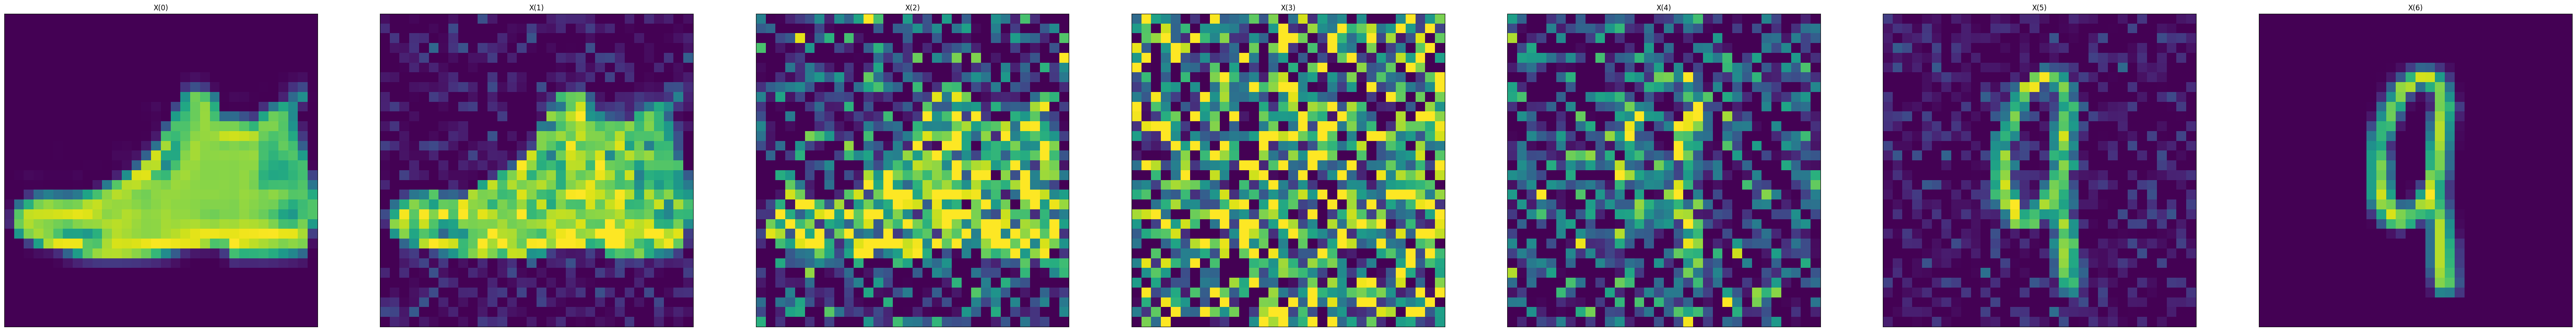

In [11]:
D_X_fixed, D_Y_fixed = D_XY_sampler.sample(5)
print(f"{D_X_fixed.shape = }")
D_X_fixed = D_X_fixed.flatten(start_dim=0, end_dim=1)
D_Y_fixed = D_Y_fixed.flatten(start_dim=0, end_dim=1)

print(f"{D_X_fixed.shape = }")
draw_all_pivotal(D_X_fixed[0], D_Y_fixed[0], DIFFUSION_STEPS, PIVOTAL_LIST)

### initialize networks


In [12]:
SDEs, BETA_NETs = [], []
SDE_OPTs, BETA_NET_OPTs = [], []
SDE_SCHEDULERs, BETA_NET_SCHEDULERs = [], []

for i in range(len(PIVOTAL_LIST) * 2 - 2):
    sde = CUNet(
        DATASET1_CHANNELS, DATASET2_CHANNELS, TIME_DIM, base_factor=UNET_BASE_FACTOR
    ).cuda()

    sde = SDE(
        shift_model=sde,
        epsilon=EPSILON,
        n_steps=N_STEPS,
        time_dim=TIME_DIM,
        n_last_steps_without_noise=N_LAST_STEPS_WITHOUT_NOISE,
        use_positional_encoding=USE_POSITIONAL_ENCODING,
        use_gradient_checkpoint=USE_GRADIENT_CHECKPOINT,
        predict_shift=PREDICT_SHIFT,
        image_input=True,
    ).cuda()
    SDEs.append(sde)

    beta_net = ResNet_D(IMG_SIZE, nc=DATASET2_CHANNELS).cuda()
    beta_net.apply(weights_init_D)
    BETA_NETs.append(beta_net)

    sde_opt = torch.optim.Adam(
        sde.parameters(), lr=SDE_LR, weight_decay=1e-10, betas=(SDE_BETA, 0.999)
    )
    beta_net_opt = torch.optim.Adam(
        beta_net.parameters(),
        lr=BETA_NET_LR,
        weight_decay=1e-10,
        betas=(BETA_NET_BETA, 0.999),
    )
    SDE_OPTs.append(sde_opt)
    BETA_NET_OPTs.append(beta_net_opt)

    sde_scheduler = torch.optim.lr_scheduler.MultiStepLR(
        sde_opt, milestones=[1500, 2500, 4000, 5500, 7000], gamma=0.5
    )
    beta_net_scheduler = torch.optim.lr_scheduler.MultiStepLR(
        beta_net_opt, milestones=[1500, 2500, 4000, 5500, 7000], gamma=0.5
    )
    SDE_SCHEDULERs.append(sde_scheduler)
    BETA_NET_SCHEDULERs.append(beta_net_scheduler)


if len(DEVICE_IDS) > 1 and CONTINUE["sde"] == -1 and CONTINUE["iteration"] == -1:
    for i in range(len(SDEs)):
        SDEs[i] = nn.DataParallel(SDEs[i], device_ids=DEVICE_IDS)
        BETA_NETs[i] = nn.DataParallel(BETA_NETs[i], device_ids=DEVICE_IDS)

        print("T params:", np.sum([np.prod(p.shape) for p in SDEs[0].parameters()]))
        print(
            "D params:", np.sum([np.prod(p.shape) for p in BETA_NETs[0].parameters()])
        )

logging.info("Initialize models")

#### Load weights for continue training


In [13]:
CKPT_DIR = os.path.join(OUTPUT_PATH, f"iter{CONTINUE["iteration"]}/")
if CONTINUE["iteration"] > -1:
    for i in range(len(SDEs)):
        SDEs[i].load_state_dict(torch.load(os.path.join(CKPT_DIR, f"sde{i}.pt")))
        SDE_OPTs[i].load_state_dict(
            torch.load(os.path.join(CKPT_DIR, f"sde_opt{i}.pt"))
        )
        SDE_SCHEDULERs[i].load_state_dict(
            torch.load(os.path.join(CKPT_DIR, f"sde_scheduler{i}.pt"))
        )

        BETA_NETs[i].load_state_dict(
            torch.load(os.path.join(CKPT_DIR, f"beta_net{i}.pt"))
        )
        BETA_NET_OPTs[i].load_state_dict(
            torch.load(os.path.join(CKPT_DIR, f"beta_net_opt{i}.pt"))
        )
        BETA_NET_SCHEDULERs[i].load_state_dict(
            torch.load(os.path.join(CKPT_DIR, f"beta_net_scheduler{i}.pt"))
        )

        if len(DEVICE_IDS) > 1:
            SDEs[i] = nn.DataParallel(sde, device_ids=DEVICE_IDS)
            BETA_NETs[i] = nn.DataParallel(beta_net, device_ids=DEVICE_IDS)

    logging.info(f"Continue training at iteration {CONTINUE["iteration"]}")

### training


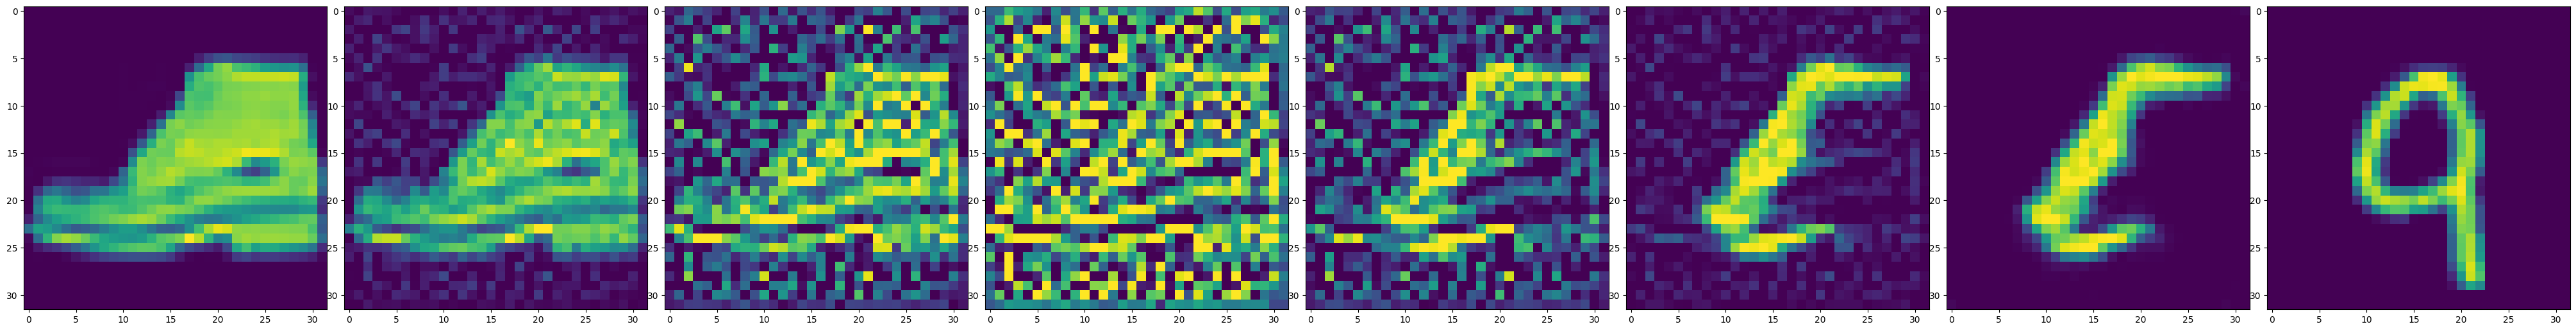

X_fixed results:


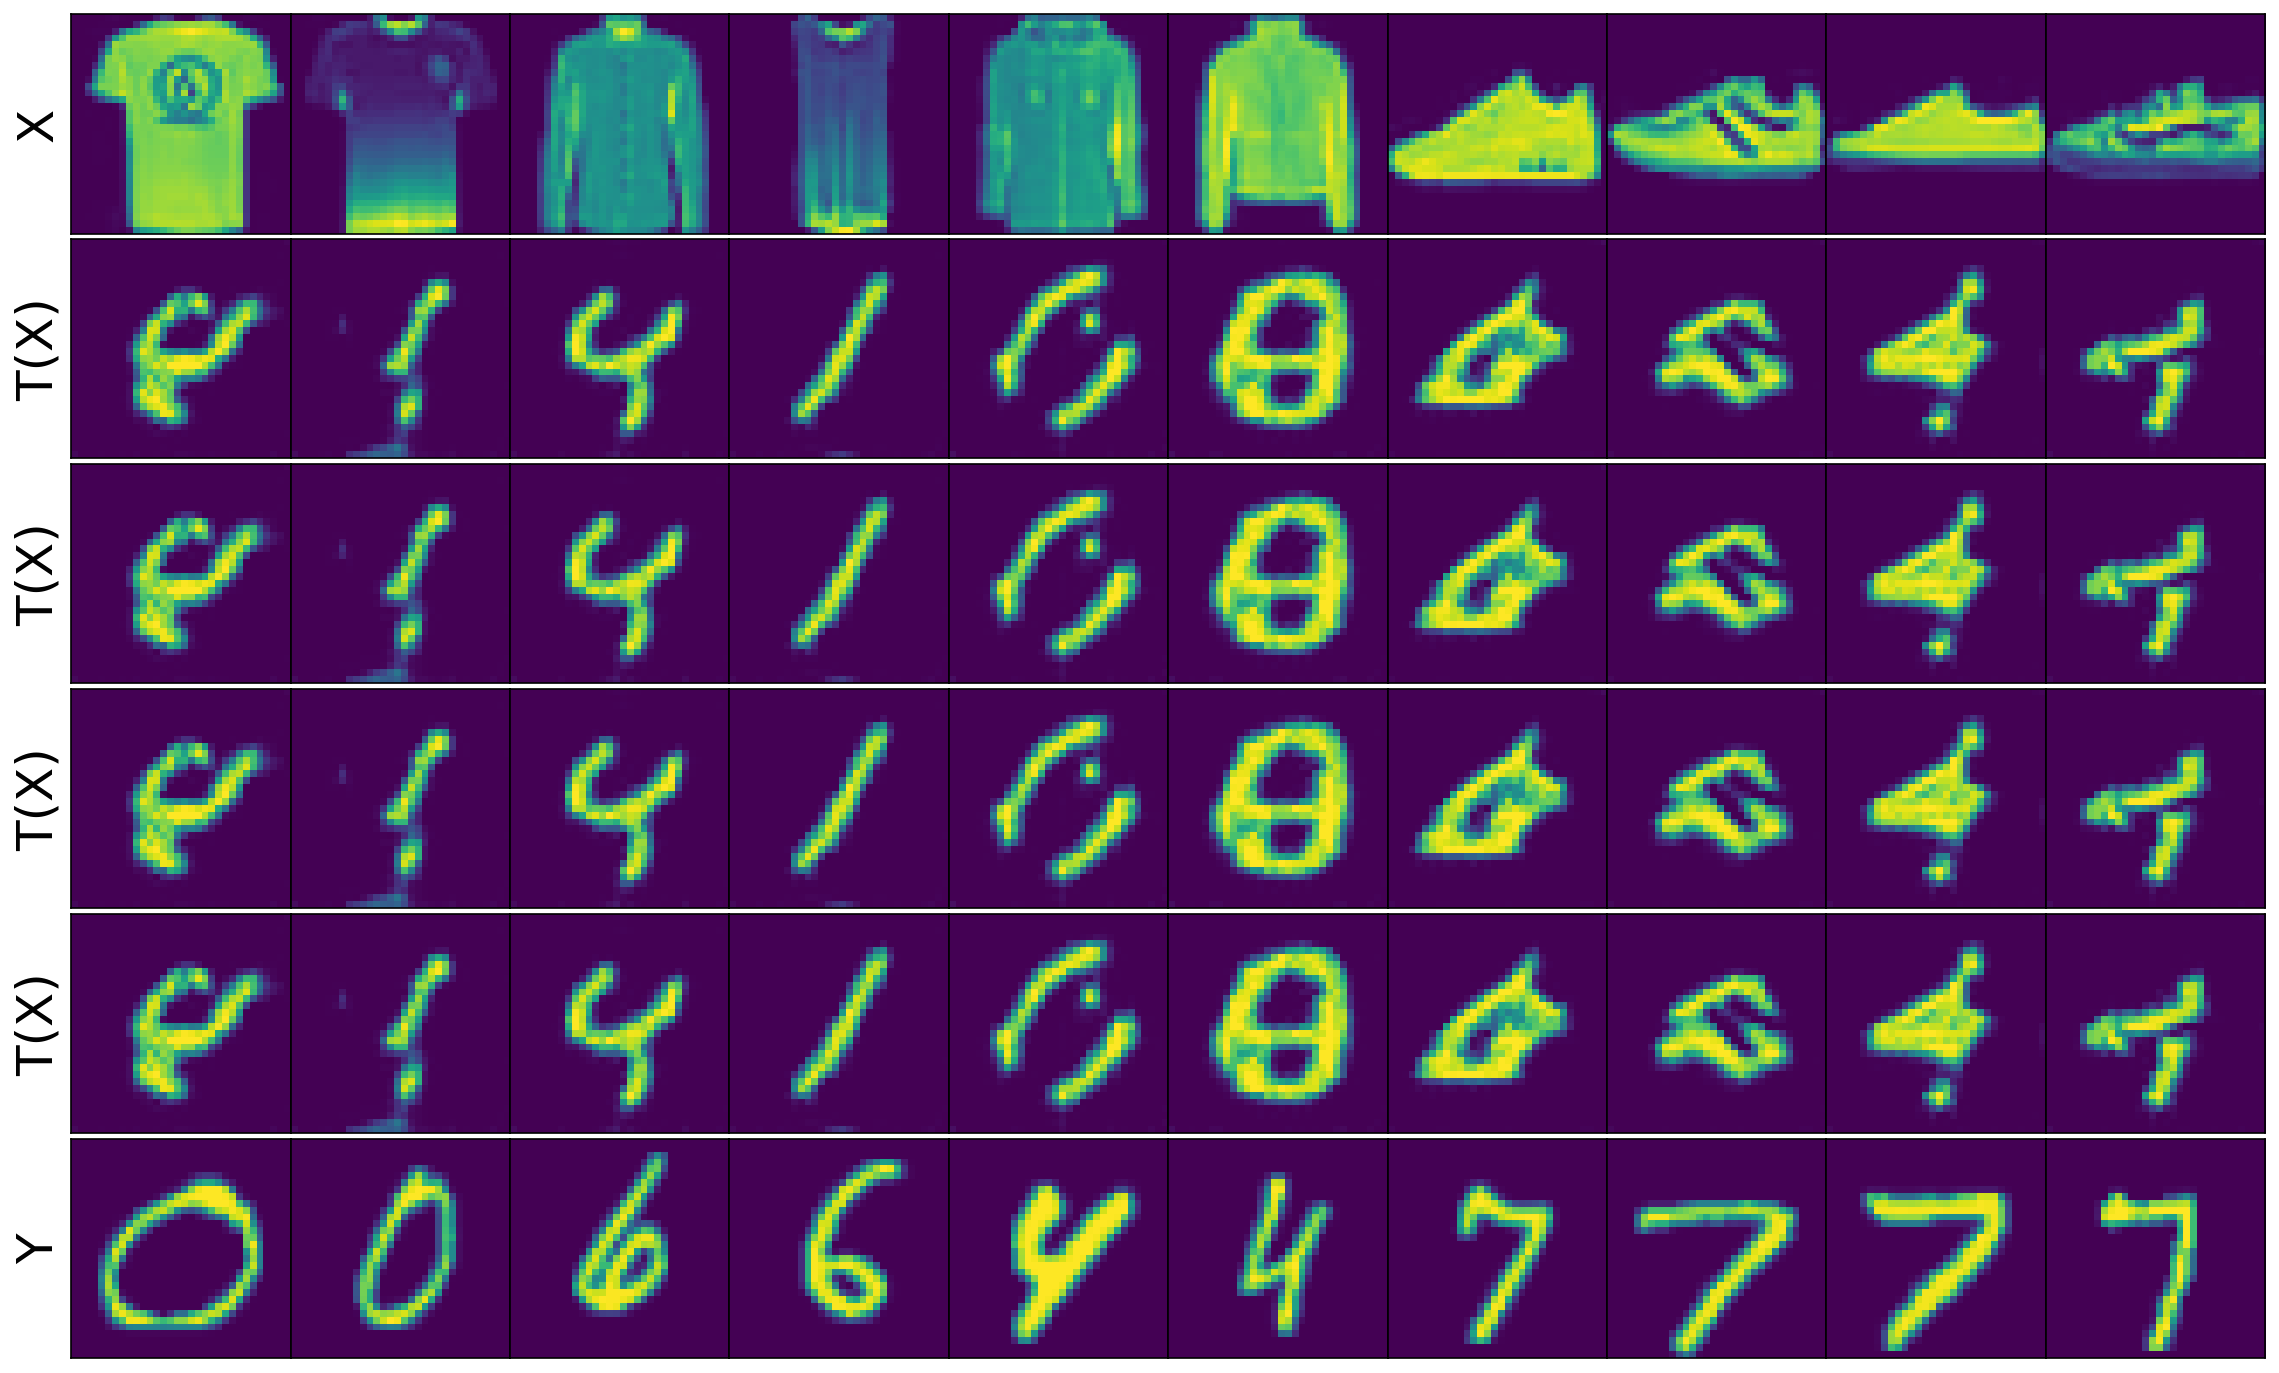

X_random results:


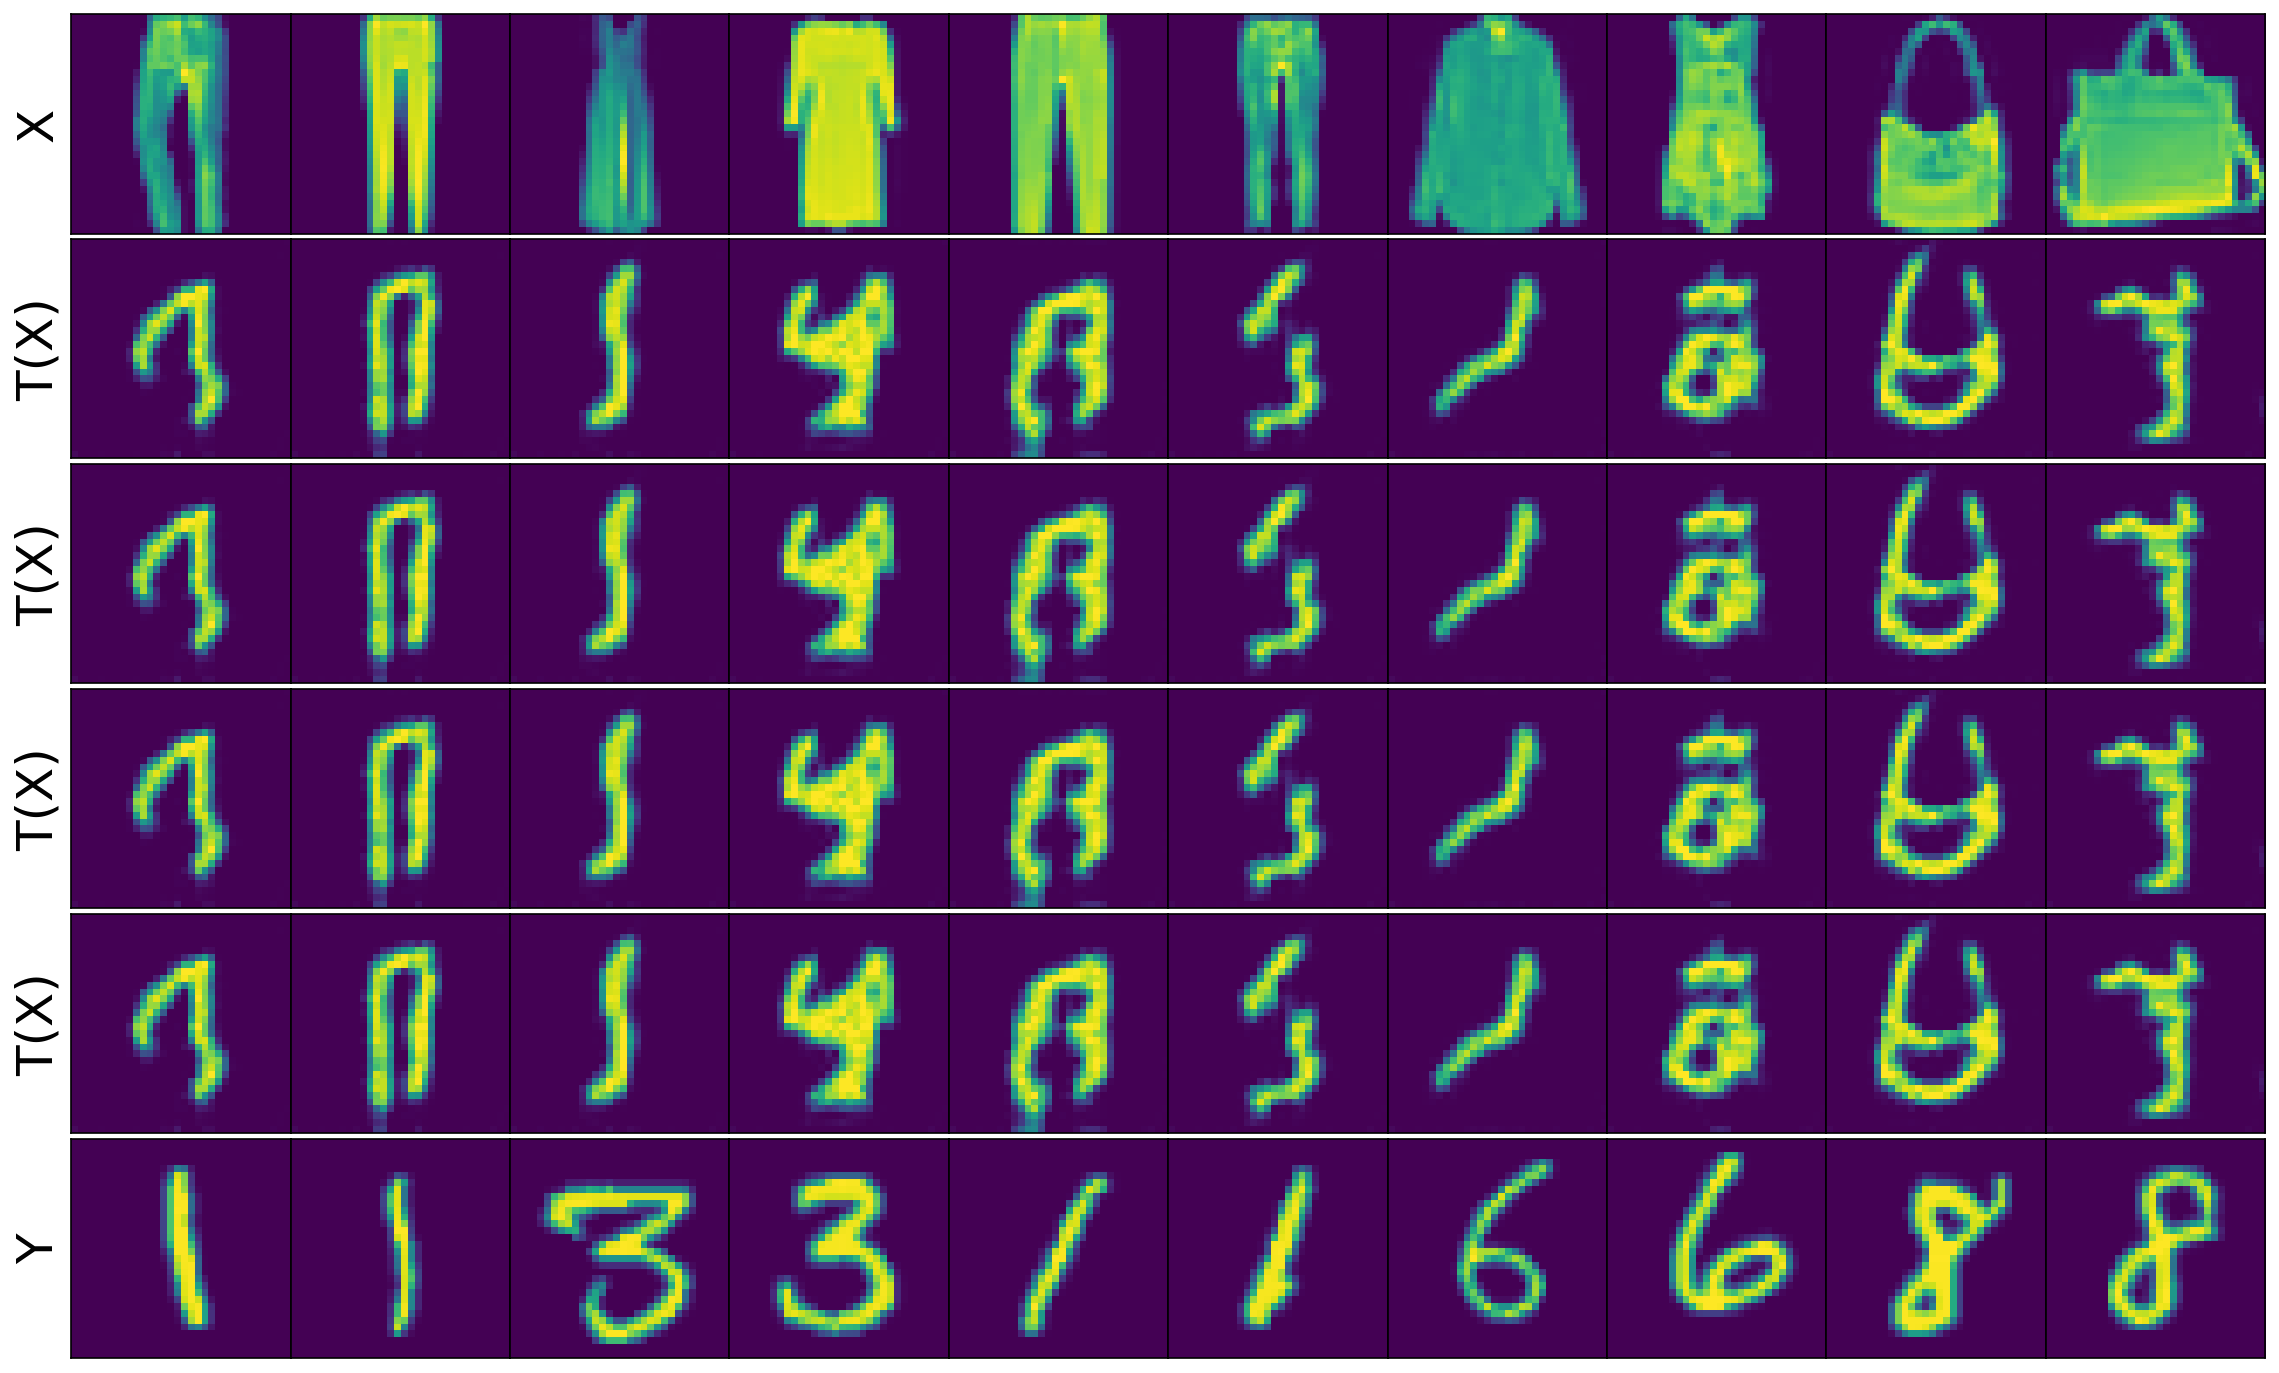

100%|██████████| 2001/2001 [15:22:35<00:00, 27.66s/it]


In [14]:
training_linked_mapping(
    XY_sampler,
    SDEs,
    BETA_NETs,
    SDE_OPTs,
    BETA_NET_OPTs,
    SDE_SCHEDULERs,
    BETA_NET_SCHEDULERs,
    OUTER_ITERS,
    INNER_ITERS,
    DIFFUSION_STEPS,
    PIVOTAL_LIST,
    BATCH_SIZE,
)

### saving model

each sub mapping model has been saved at training time, this is option code


In [ ]:
for i, sde in enumerate(SDEs):
    path = os.path.join(OUTPUT_PATH, f"sde{i}.pt")
    torch.save(sde.state_dict(), path)